In [1]:
import random
import cv2
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data

from PIL import Image, ImageFile
from torch.utils import data as data_utils
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split, Dataset, SubsetRandomSampler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# cv2는 이미지 색상을 BGR로 불러와서, RGB 색상으로 변환해주는 함수
def BGR2RGB(image):
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return rgb_img

### Normalization ###

# 컬러 이미지 Normalization 함수
def Normalization_Color(image):
    normalize_img = cv2.normalize(BGR2RGB(image), None, 0, 255, cv2.NORM_MINMAX) # RGB 이미지에 cv2.normalize() 적용
    shape = normalize_img.shape # 제대로 적용됐는지 이미지 shape 확인하기 위한 용도
    return normalize_img, shape

# 그레이 이미지 Normalization 함수
def Normalization_Gray(image):
    img = cv2.cvtColor(BGR2RGB(image), cv2.COLOR_RGB2GRAY) # RGB 색상을 Gray 색상으로 변환
    normalize_img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX) # Gray 이미지에 cv2.normalize() 적용
    shape = normalize_img.shape # 제대로 적용됐는지 이미지 shape 확인하기 위한 용도
    return normalize_img, shape

# 컬러 이미지 HE 함수
def HE_Color(image):
    '''
    컬러 이미지에 HE 적용할 땐 밝기 정보와 색상 정보를 분리한 후, 밝기 정보인 Y에 대해서만 HE 수행함
    색상 정보는 변환되지 않아서 색감이 그대로 유지되고, 밝기 정보인 Y에 대해서만 명암비가 증가하게 됨
    '''
    img = cv2.cvtColor(BGR2RGB(image), cv2.COLOR_RGB2YCrCb) # RGB 색상을 YCrCb 색상으로 변환
    img_planes = cv2.split(img) # Y(밝기 정보), Cr & Cb(색상 정보)로 split
    img_planes_0 = cv2.equalizeHist(img_planes[0]) # 밝기 정보인 Y에 대해서만 cv2.equalizeHist() 적용
    merge_img = cv2.merge([img_planes_0, img_planes[1], img_planes[2]]) # 변환된 Y와 색상 정보 merge
    he_img = cv2.cvtColor(merge_img, cv2.COLOR_YCrCb2RGB) # YCrCb 색상을 RGB 색상으로 변환
    shape = he_img.shape # 제대로 적용됐는지 이미지 shape 확인하기 위한 용도
    return he_img, shape

# 그레이 이미지 HE 함수
def HE_Gray(image):
    img = cv2.cvtColor(BGR2RGB(image), cv2.COLOR_RGB2GRAY) # RGB 색상을 Gray 색상으로 변환
    he_img = cv2.equalizeHist(img) # Gray 이미지에 cv2.equalizeHist() 적용
    shape = he_img.shape # 제대로 적용됐는지 이미지 shape 확인하기 위한 용도
    return he_img, shape

In [4]:
# grayscale None
# class CustomTransform:
#     def __call__(self, img):
#         img = np.array(img)
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#         #img, _ = HE_Gray(img)
#         #img, _ = Normalization_Gray(img)
#         return Image.fromarray(img)

# grayscale HE
# class CustomTransform:
#     def __call__(self, img):
#         img = np.array(img)
#         #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#         img, _ = HE_Gray(img)
#         #img, _ = Normalization_Gray(img)
#         return Image.fromarray(img)

# grayscale Norm
# class CustomTransform:
#     def __call__(self, img):
#         img = np.array(img)
#         #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#         #img, _ = HE_Gray(img)
#         img, _ = Normalization_Gray(img)
#         return Image.fromarray(img)

# grayscale Norm&HE
# class CustomTransform:
#     def __call__(self, img):
#         img = np.array(img)
#         #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#         img, _ = HE_Gray(img)
#         img, _ = Normalization_Gray(img)
#         return Image.fromarray(img)


In [5]:
class CustomTransform:
    def __call__(self, img):
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        #img, _ = HE_Gray(img)
        #img, _ = Normalization_Gray(img)
        return Image.fromarray(img)



data_transforms = {
    'train': transforms.Compose([
        CustomTransform(),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        CustomTransform(),
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])
}

In [6]:
# 원래 코드의 데이터셋 로딩 부분을 수정
train_dataset = datasets.ImageFolder(r"/content/drive/MyDrive/remove_dataset/train", transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(r"/content/drive/MyDrive/remove_dataset/test", transform=data_transforms['test'])

In [7]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

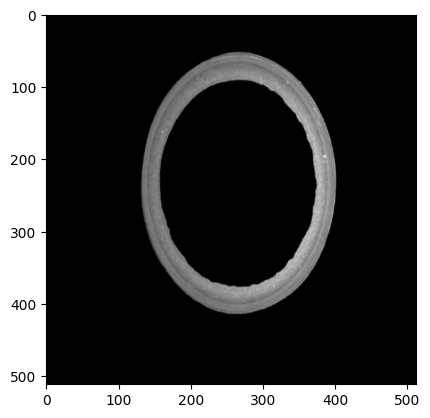

In [8]:
## StartifiedShuufleSplit
sss = StratifiedShuffleSplit(n_splits = 5, test_size = val_size, random_state = 42)
train_indices, val_indices = next(sss.split(train_dataset, train_dataset.targets))
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(train_dataset, batch_size = 32, sampler = train_sampler)
val_loader = DataLoader(train_dataset, batch_size = 32, sampler = val_sampler)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

image, label = next(iter(train_loader))
image.shape, label.shape
plt.imshow(image[0, 0, :, :], cmap='gray')

In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.bencmark = True

seed_everything(42)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
def depthwise_separable_conv(input_dim, output_dim):

    depthwise_convolution = nn.Conv2d(input_dim, input_dim, kernel_size=3, padding=1, groups=input_dim, bias=False)
    pointwise_convolution = nn.Conv2d(input_dim, output_dim, kernel_size=1, bias=False)

    model = nn.Sequential(
        depthwise_convolution,
        pointwise_convolution

    )

    return model

In [12]:
class entry_flow(nn.Module):
    def __init__(self):
        super(entry_flow, self).__init__()

        self.conv2d_init_1 = nn.Conv2d(in_channels = 1,
                                       out_channels = 32,
                                       kernel_size = 3,
                                       stride = 2,
                                      )

        self.conv2d_init_2 = nn.Conv2d(in_channels = 32,
                                       out_channels = 64,
                                       kernel_size = 3,
                                       stride = 1,
                                      )


        self.layer_1 = nn.Sequential(
            depthwise_separable_conv(input_dim = 64, output_dim = 128),
            nn.ReLU(),
            depthwise_separable_conv(input_dim = 128, output_dim = 128),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        )

        self.conv2d_1 = nn.Conv2d(in_channels = 64,
                                  out_channels = 128,
                                  kernel_size = 1,
                                  stride = 2
                                  )

        self.layer_2 = nn.Sequential(
            depthwise_separable_conv(input_dim = 128, output_dim = 256),
            nn.ReLU(),
            depthwise_separable_conv(input_dim = 256, output_dim = 256),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        )

        self.conv2d_2 = nn.Conv2d(in_channels = 128,
                                  out_channels = 256,
                                  kernel_size = 1,
                                  stride = 2
                                  )

        self.layer_3 = nn.Sequential(
            depthwise_separable_conv(input_dim = 256, output_dim = 728),
            nn.ReLU(),
            depthwise_separable_conv(input_dim = 728, output_dim = 728),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        )

        self.conv2d_3 = nn.Conv2d(in_channels = 256,
                                  out_channels = 728,
                                  kernel_size = 1,
                                  stride = 2
                                  )

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv2d_init_1(x)
        x = self.relu(x)
        x = self.conv2d_init_2(x)
        x = self.relu(x)

        output1_1 = self.layer_1(x)
        output1_2 = self.conv2d_1(x)
        output1_3 = output1_1 + output1_2


        output2_1 = self.layer_2(output1_3)
        output2_2 = self.conv2d_2(output1_3)
        output2_3 = output2_1 + output2_2


        output3_1 = self.layer_3(output2_3)
        output3_2 = self.conv2d_3(output2_3)
        output3_3 = output3_1 + output3_2
        y = output3_3

        return y

In [13]:
class middle_flow(nn.Module):
    def __init__(self):
        super(middle_flow, self).__init__()

        for i in range(7):
            layers = nn.Sequential(
                    nn.ReLU(),
                    depthwise_separable_conv(input_dim = 728, output_dim = 728),
                    nn.ReLU(),
                    depthwise_separable_conv(input_dim = 728, output_dim = 728),
                    nn.ReLU(),
                    depthwise_separable_conv(input_dim = 728, output_dim = 728)
                )
            self.add_module(f"layer_{i}", layers) # 각 레이어에 고유한 이름 부여

    def forward(self, x):
        for i in range(7):
            x_temp = getattr(self, f"layer_{i}")(x)
            x = x + x_temp
        return x

In [14]:
# class middle_flow(nn.Module):
#     def __init__(self):
#         super(middle_flow, self).__init__()

#         self.module_list = nn.ModuleList()

#         layers = nn.Sequential(
#                 nn.ReLU(),
#                 depthwise_separable_conv(input_dim = 728, output_dim = 728),
#                 nn.ReLU(),
#                 depthwise_separable_conv(input_dim = 728, output_dim = 728),
#                 nn.ReLU(),
#                 depthwise_separable_conv(input_dim = 728, output_dim = 728)
#             )

#         for i in range(7):
#             self.module_list.append(layers)

#     def forward(self, x):
#         for layer in self.module_list:
#             x_temp = layer(x)
#             x = x + x_temp

#         return x

In [15]:
class exit_flow(nn.Module):
    def __init__(self, growth_rate=32):
        super(exit_flow, self).__init__()

        self.separable_network = nn.Sequential(
            nn.ReLU(),
            depthwise_separable_conv(input_dim = 728, output_dim = 728),
            nn.ReLU(),
            depthwise_separable_conv(input_dim = 728, output_dim = 1024),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2d_1 = nn.Conv2d(in_channels = 728,
                                  out_channels = 1024,
                                  kernel_size = 1,
                                  stride = 2
                                  )

        self.separable_conv_1 = depthwise_separable_conv(input_dim = 1024, output_dim = 1536)
        self.separable_conv_2 = depthwise_separable_conv(input_dim = 1536, output_dim = 2048)

        self.relu = nn.ReLU()
        self.avgpooling = nn.AdaptiveAvgPool2d((1))

        self.fc_layer = nn.Linear(2048, 2)

    def forward(self, x):
        output1_1 = self.separable_network(x)
        output1_2 = self.conv2d_1(x)
        output1_3 = output1_1 + output1_2

        y = self.separable_conv_1(output1_3)
        y = self.relu(y)
        y = self.separable_conv_2(y)
        y = self.relu(y)
        y = self.avgpooling(y)

        y = y.view(-1, 2048)
        y= self.fc_layer(y)


        return y

In [16]:
class Xception(nn.Module):
    def __init__(self):
        super(Xception, self).__init__()
        self.entry_flow = entry_flow()
        self.middle_flow = middle_flow()
        self.exit_flow = exit_flow()



    def forward(self, x):
        x = self.entry_flow(x)
        x = self.middle_flow(x)
        x = self.exit_flow(x)

        return x

In [17]:
model = Xception().to(device)
learning_rate = 1e-4
epochs = 200
batch_size = 16
class_weight = torch.tensor([0.35, 0.65])
criterion = torch.nn.CrossEntropyLoss(weight = class_weight).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [18]:
def train(model, train_loader, val_loader, epochs, learning_rate, patience):

    best_loss = float('inf')
    best_model = None
    epochs_without_importvement = 0

    for epoch in range(epochs):
        model.train()
        avg_loss = 0

        for X, Y in train_loader:
            X = X.to(device)
            Y = Y.to(device)

            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, Y)
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()

        avg_loss /= len(train_loader)

        val_loss = evaluate(model, val_loader)

        print(f'Epoch : {epoch + 1}, Train Loss : {avg_loss:.4f}, Validation Loss: {val_loss:.4f}')

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict().copy()
            print('Model Saved')
            epochs_without_importvement = 0

        else:
            epochs_without_importvement += 1

        if epochs_without_importvement >= patience:
            print(f'Early stopping: No improvement in validation loss for {patience} epochs.')
            break

    return best_model

In [19]:
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for X, Y in dataloader:
            X = X.to(device)
            Y = Y.to(device)
            output = model(X)
            loss = criterion(output, Y)
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [20]:
patience = 50
best_model = train(model, train_loader, val_loader, epochs, learning_rate, patience)
model.load_state_dict(best_model)

Epoch : 1, Train Loss : 0.6931, Validation Loss: 0.6914
Model Saved
Epoch : 2, Train Loss : 0.6931, Validation Loss: 0.6898
Model Saved
Epoch : 3, Train Loss : 0.6930, Validation Loss: 0.6883
Model Saved
Epoch : 4, Train Loss : 0.6930, Validation Loss: 0.6872
Model Saved
Epoch : 5, Train Loss : 0.6930, Validation Loss: 0.6869
Model Saved
Epoch : 6, Train Loss : 0.6930, Validation Loss: 0.6872
Epoch : 7, Train Loss : 0.6930, Validation Loss: 0.6878
Epoch : 8, Train Loss : 0.6930, Validation Loss: 0.6884
Epoch : 9, Train Loss : 0.6930, Validation Loss: 0.6889
Epoch : 10, Train Loss : 0.6930, Validation Loss: 0.6892
Epoch : 11, Train Loss : 0.6930, Validation Loss: 0.6892
Epoch : 12, Train Loss : 0.6930, Validation Loss: 0.6890
Epoch : 13, Train Loss : 0.6930, Validation Loss: 0.6886
Epoch : 14, Train Loss : 0.6930, Validation Loss: 0.6882
Epoch : 15, Train Loss : 0.6930, Validation Loss: 0.6878
Epoch : 16, Train Loss : 0.6929, Validation Loss: 0.6876
Epoch : 17, Train Loss : 0.6929, Vali

<All keys matched successfully>

In [21]:
model.eval()
test_loss = 0
correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for X, Y in test_loader:
        X = X.to(device)
        Y = Y.to(device)
        output = model(X)
        test_loss += criterion(output, Y).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(Y.view_as(pred)).sum().item()

        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(Y.cpu().numpy())

test_loss /= len(test_loader.dataset)
accuracy = correct / len(test_loader.dataset)

print(f"Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2%}")

Test Loss: 0.0082, Accuracy: 100.00%


In [22]:
# F1 score 계산
f1_micro = f1_score(all_labels, all_preds, average='micro')
f1_macro = f1_score(all_labels, all_preds, average='macro')
f1_weighted = f1_score(all_labels, all_preds, average='weighted')
print(f"F1 Score (Micro): {f1_micro:.8f}")
print(f"F1 Score (Macro): {f1_macro:.8f}")
print(f"F1 Score (Weighted): {f1_weighted:.8f}")

# Precision 계산
precision_micro = precision_score(all_labels, all_preds, average='micro')
precision_macro = precision_score(all_labels, all_preds, average='macro')
precision_weighted = precision_score(all_labels, all_preds, average='weighted')
print(f"Precision (Micro): {precision_micro:.8f}")
print(f"Precision (Macro): {precision_macro:.8f}")
print(f"Precision (Weighted): {precision_weighted:.8f}")

# Recall 계산
recall_micro = recall_score(all_labels, all_preds, average='micro')
recall_macro = recall_score(all_labels, all_preds, average='macro')
recall_weighted = recall_score(all_labels, all_preds, average='weighted')
print(f"Recall (Micro): {recall_micro:.8f}")
print(f"Recall (Macro): {recall_macro:.8f}")
print(f"Recall (Weighted): {recall_weighted:.8f}")

# Confusion Matrix 계산
cm = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(cm)

# 분류 리포트 출력
class_names = [str(num) for num in torch.arange(2).tolist()]
classification_rep = classification_report(all_labels, all_preds, target_names=class_names)
print('Classification Report:')
print(classification_rep)



# 성능 지표 계산
f1 = f1_score(all_labels, all_preds)
acc = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

F1 Score (Micro): 1.00000000
F1 Score (Macro): 1.00000000
F1 Score (Weighted): 1.00000000
Precision (Micro): 1.00000000
Precision (Macro): 1.00000000
Precision (Weighted): 1.00000000
Recall (Micro): 1.00000000
Recall (Macro): 1.00000000
Recall (Weighted): 1.00000000
Confusion Matrix:
[[3 0]
 [0 2]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5

F1 Score: 1.0000
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
Confusion Matrix:
[[3 0]
 [0 2]]


In [23]:
PATH = r'/content/drive/MyDrive/Xception_1_512_None.pth'

torch.save(model, PATH)